#Downloading Dataset

In [1]:
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json /content/

In [2]:
! pip install -q kaggle

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


I used the anime face dataset on [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset) provided by splcher

In [ ]:
!kaggle datasets download 'splcher/animefacedataset'
!unzip animefacedataset.zip
!rm -r celeba-dataset.zip

I used the celebA face dataset on [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) provided by jessicali9530

In [ ]:
!kaggle datasets download 'jessicali9530/celeba-dataset'
!unzip celeba-dataset.zip
!rm -r celeba-dataset.zip

#Importing Libraries

In [6]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model, load_model
from keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback, TensorBoard, BackupAndRestore
from keras import regularizers
import numpy as np
import os
import datetime
import gc #garbage collector
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import psutil
from random import sample
from sklearn.decomposition import PCA

#Dataset Preprocessing

All images are squared so we just define one dim and use it twice

In [7]:
hight = 64

In [8]:
path_real_img = "/content/img_align_celeba/img_align_celeba/"
path_anime_img = "/content/images/"

Loading images paths

In [9]:
real_face = [path_real_img + i for i in os.listdir(path_real_img)]
print(len(real_face))
print(real_face[:3])

202599
['/content/img_align_celeba/img_align_celeba/173073.jpg', '/content/img_align_celeba/img_align_celeba/103908.jpg', '/content/img_align_celeba/img_align_celeba/125819.jpg']


In [10]:
anime_face = [path_anime_img + i for i in os.listdir(path_anime_img)]
print(len(anime_face))
print(anime_face[:3])

63565
['/content/images/60260_2018.jpg', '/content/images/25077_2009.jpg', '/content/images/884_2000.jpg']


Creating the dataset

In [21]:
real_face_ds = []
for i in tqdm(real_face[:10000]):
  real_face_ds.append(cv2.resize(np.array(cv2.imread(i)[:,:,::-1]),(hight, hight)).astype("float32")/255.0)

100%|██████████| 10000/10000 [00:22<00:00, 447.12it/s]


In [22]:
anime_face_ds = []
for i in tqdm(anime_face[:10000]):
  anime_face_ds.append(cv2.resize(np.array(cv2.imread(i)[:,:,::-1]),(hight, hight)).astype("float32")/255.0)

100%|██████████| 10000/10000 [00:11<00:00, 906.10it/s]


In [23]:
anime_face_ds = np.array(anime_face_ds)
real_face_ds = np.array(real_face_ds)

In [24]:
anime_face_ds.shape, real_face_ds.shape

((10000, 64, 64, 3), (10000, 64, 64, 3))

Show some exemples

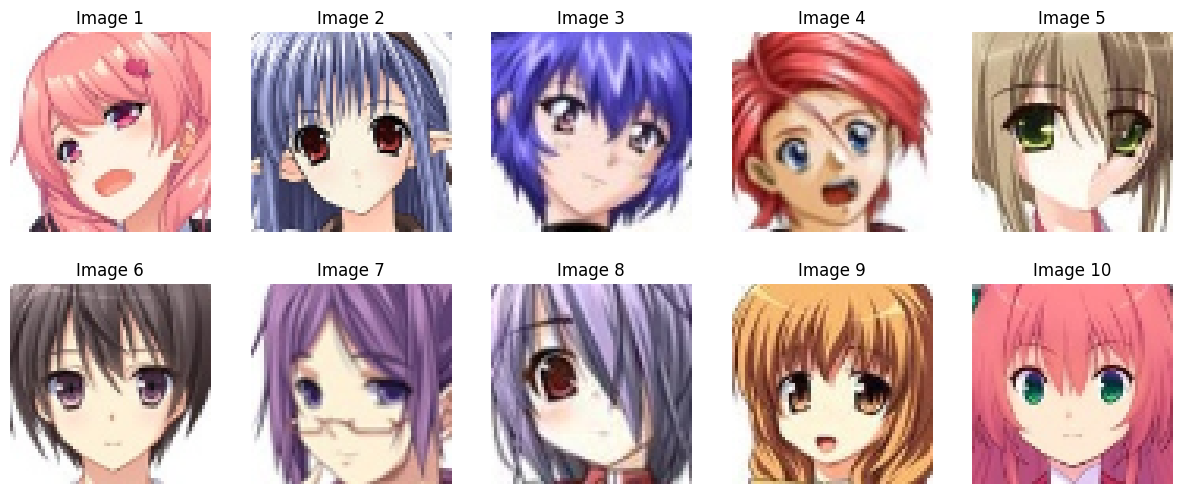

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      ax[i, j].imshow(anime_face_ds[i*5 + j])
      ax[i, j].axis('off')
      ax[i, j].set_title(f'Image {i*5 + j + 1}')
plt.show()

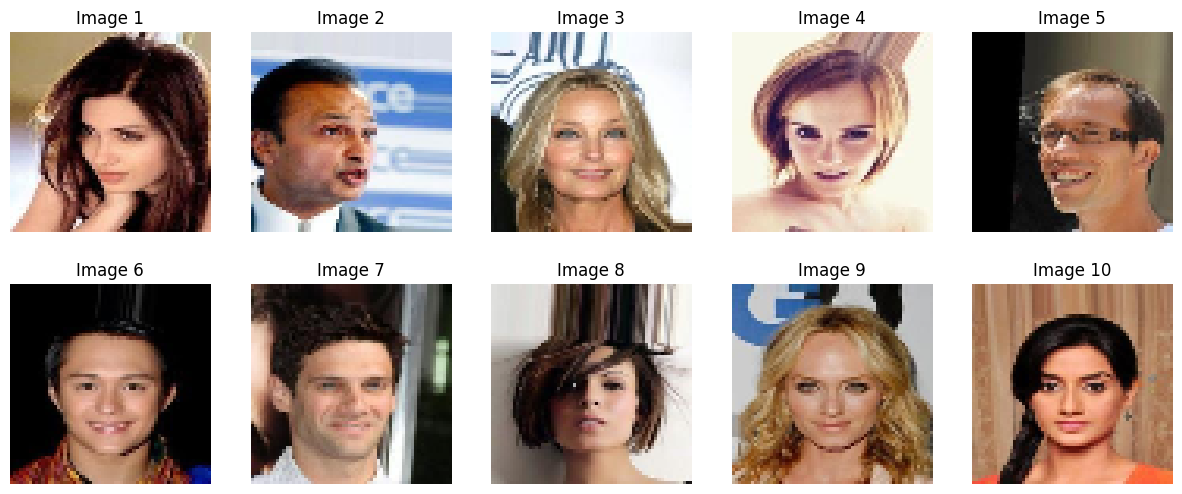

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      ax[i, j].imshow(real_face_ds[i*5 + j])
      ax[i, j].axis('off')
      ax[i, j].set_title(f'Image {i*5 + j + 1}')
plt.show()

In [30]:
anime = load_model('/content/drive/MyDrive/AutoEncoders/animeFaceModel.h5')
anime.load_weights('/content/drive/MyDrive/AutoEncoders/anime_face_best_model_64.h5')

In [31]:
real = load_model('/content/drive/MyDrive/AutoEncoders/animeFaceModel.h5')
real.load_weights('/content/drive/MyDrive/AutoEncoders/real_face_best_model_64.h5')

In [32]:
anime_encoder = anime.get_layer(name='encoder')
anime_decoder = anime.get_layer(name='decoder')

In [33]:
real_encoder = real.get_layer(name='encoder')
real_decoder = real.get_layer(name='decoder')

In [ ]:
inputShape = (hight, hight, 3)
inputs = Input(shape=inputShape)

In [ ]:
realToAnime = Model(inputs, anime_decoder(real_encoder(inputs)), name="realToAnime")
animeToReal = Model(inputs, real_decoder(anime_encoder(inputs)), name="animeToReal")

In [ ]:
decodedToAnime = anime.predict(real_face_ds[:100])

4/4 [==============================] - 3s 634ms/step


In [ ]:
randimg = sample(range(decodedToAnime.shape[0]), 5)

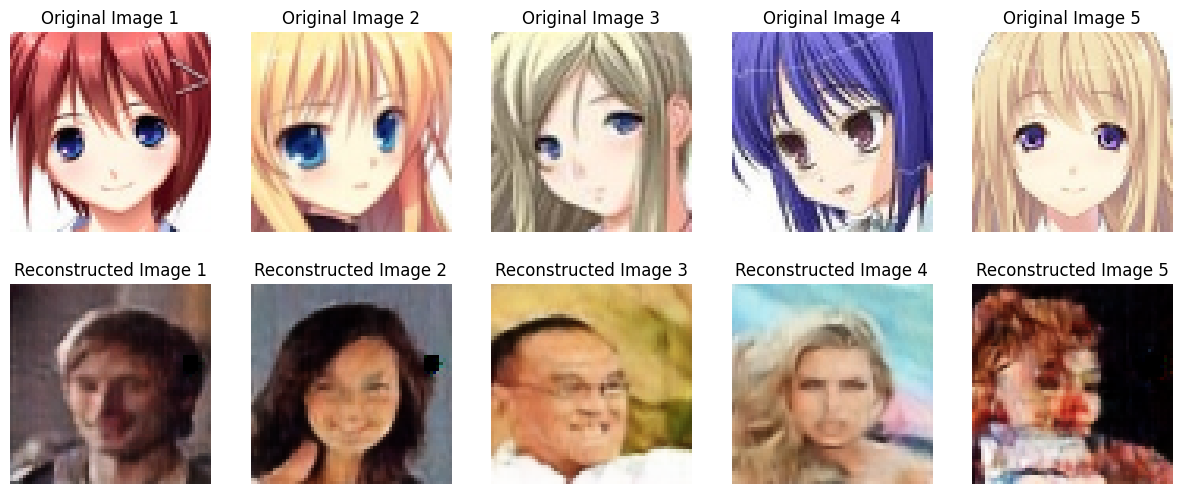

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      if i == 0:
        ax[i, j].imshow(anime_face_ds[1*5 + randimg[j]])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Original Image {0*5 + j + 1}')
      else:
        ax[i, j].imshow(decodedToAnime[1*5 + randimg[j]])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Reconstructed Image {0*5 + j + 1}')

plt.show()

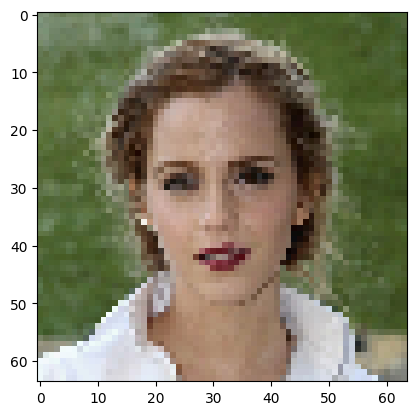

In [ ]:
img = cv2.imread('/content/emma-watson.jpeg')[:,:,::-1]
img = cv2.resize(img, (64, 64))
plt.imshow(img)

In [ ]:
img = np.expand_dims(img,axis=0)

In [ ]:
img.shape

(1, 64, 64, 3)

In [ ]:
decodedToAnime = realToAnime.predict(img)

1/1 [==============================] - 0s 313ms/step


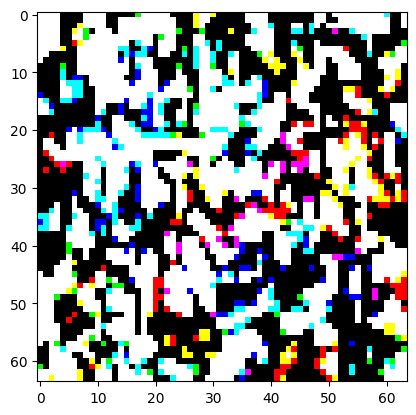

In [ ]:
plt.imshow(decodedToAnime[0])

In [34]:
real_decoded = anime_encoder.predict(real_face_ds)

313/313 [==============================] - 59s 185ms/step


In [35]:
anime_decoded = real_encoder.predict(anime_face_ds)

313/313 [==============================] - 49s 157ms/step


In [37]:
pca = PCA(n_components=2)

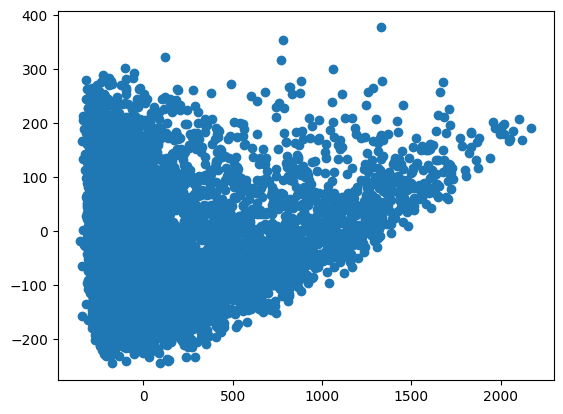

In [40]:
encoded_imgs_pca = pca.fit_transform(real_decoded)
plt.scatter(encoded_imgs_pca[:, 0], encoded_imgs_pca[:, 1])
plt.show()

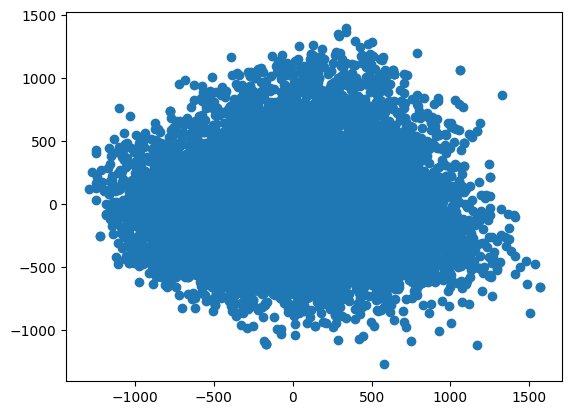

In [41]:
encoded_imgs_pca = pca.fit_transform(anime_decoded)
plt.scatter(encoded_imgs_pca[:, 0], encoded_imgs_pca[:, 1])
plt.show()